In [1]:
import numpy as np
import time
import dask.array as da
import matplotlib.pyplot as plt
import warnings

# Q1

In [2]:
# Set the random seed for reproducibility
np.random.seed(1)

# Create the NumPy array from random integers in range [1, 10) means 1, 2, 3, 4, 5, 6, 7, 8, 9
array_numpy = np.random.randint(1, 10, size=(30000, 20000))

print(f"Array shape: {array_numpy.shape}")
print(f"Array size: {array_numpy.size} elements")
print(f"Memory usage: {array_numpy.nbytes / (1024**3):.2f} GB")

# Time the mean calculation for every row
start_time = time.time()
row_means_numpy = array_numpy.mean(axis=1)  # axis=1 means along columns (row-wise)
end_time = time.time()

numpy_time = end_time - start_time

Array shape: (30000, 20000)
Array size: 600000000 elements
Memory usage: 4.47 GB


In [3]:
print(f"NumPy row mean calculation time: {numpy_time:.4f} seconds")
print(f"Result shape: {row_means_numpy.shape}")
print(f"First 5 row means: {row_means_numpy[:5]}")

NumPy row mean calculation time: 0.5958 seconds
Result shape: (30000,)
First 5 row means: [5.01895 5.00115 5.02185 5.0171  5.0122 ]


# Q2

In [4]:
# Convert NumPy array to Dask array with chunk size (1000, 1000)
da4 = da.from_array(array_numpy, chunks=(1000, 1000))

In [5]:
print(f"Dask array shape: {da4.shape}")
print(f"Dask array chunks: {da4.chunks}")
print(f"Number of chunks: {da4.npartitions}")
print(f"Chunk size: {da4.chunksize}")
print(f"\nDask array info:")
print(da4)

Dask array shape: (30000, 20000)
Dask array chunks: ((1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000), (1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000))
Number of chunks: 600
Chunk size: (1000, 1000)

Dask array info:
dask.array<array, shape=(30000, 20000), dtype=int64, chunksize=(1000, 1000), chunktype=numpy.ndarray>


# Q3

In [6]:
# Get the data type of the array
dtype_size = da4.dtype.itemsize  # bytes per element
print(f"Data type: {da4.dtype}")
print(f"Bytes per element: {dtype_size}")

# Method 1: Calculate using NumPy methods
# Size of entire da4 array
total_elements = np.prod(da4.shape)  # 30000 * 20000
calculated_total_size = total_elements * dtype_size

print(f"\n--- Full Array (da4) ---")
print(f"Shape: {da4.shape}")
print(f"Total elements: {total_elements:,}")
print(f"Calculated size: {calculated_total_size:,} bytes ({calculated_total_size / (1024**3):.4f} GB)")

# Size of one chunk (1000, 1000)
chunk_elements = np.prod(da4.chunksize)  # 1000 * 1000
calculated_chunk_size = chunk_elements * dtype_size

print(f"\n--- Single Chunk ---")
print(f"Chunk shape: {da4.chunksize}")
print(f"Chunk elements: {chunk_elements:,}")
print(f"Calculated chunk size: {calculated_chunk_size:,} bytes ({calculated_chunk_size / (1024**2):.4f} MB)")

# Compare with Dask's reported values
print(f"\n--- Dask Reported Values ---")
print(f"Dask array nbytes: {da4.nbytes:,} bytes ({da4.nbytes / (1024**3):.4f} GB)")
print(f"Number of chunks: {da4.npartitions}")

# Verify they match
print(f"\n--- Comparison ---")
print(f"Calculated total size matches Dask? {calculated_total_size == da4.nbytes}")
print(f"Total chunks: {da4.npartitions} (should be 30×20 = 600)")

Data type: int64
Bytes per element: 8

--- Full Array (da4) ---
Shape: (30000, 20000)
Total elements: 600,000,000
Calculated size: 4,800,000,000 bytes (4.4703 GB)

--- Single Chunk ---
Chunk shape: (1000, 1000)
Chunk elements: 1,000,000
Calculated chunk size: 8,000,000 bytes (7.6294 MB)

--- Dask Reported Values ---
Dask array nbytes: 4,800,000,000 bytes (4.4703 GB)
Number of chunks: 600

--- Comparison ---
Calculated total size matches Dask? True
Total chunks: 600 (should be 30×20 = 600)


# Q4

Chunk size (1000, 1000): 0.6050 seconds
  Number of chunks: 600
  Chunk dimensions: (30, 20)

Chunk size (3000, 2000): 0.1494 seconds
  Number of chunks: 100
  Chunk dimensions: (10, 10)

Chunk size (300, 200): 6.9634 seconds
  Number of chunks: 10000
  Chunk dimensions: (100, 100)



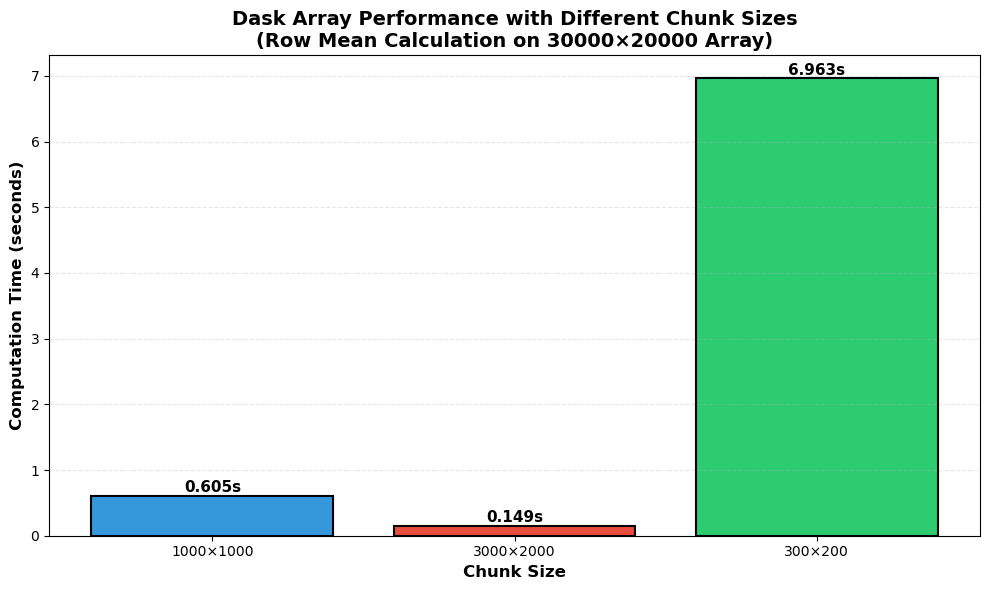


PERFORMANCE SUMMARY
1000×1000    | Time: 0.6050s | Chunks:  600 | Grid: 30×20
3000×2000    | Time: 0.1494s | Chunks:  100 | Grid: 10×10
300×200      | Time: 6.9634s | Chunks: 10000 | Grid: 100×100


In [7]:
# We'll test different chunk sizes and time the row mean calculation
chunk_sizes = [(1000, 1000), (3000, 2000), (300, 200)]
times = []
chunk_labels = []

for chunks in chunk_sizes:
    # Create dask array with specific chunk size
    da_test = da.from_array(array_numpy, chunks=chunks)
    
    # Time the row mean calculation
    start_time = time.time()
    result = da_test.mean(axis=1).compute()  # .compute() triggers actual computation
    end_time = time.time()
    
    elapsed = end_time - start_time
    times.append(elapsed)
    chunk_labels.append(f"{chunks[0]}×{chunks[1]}")
    
    print(f"Chunk size {chunks}: {elapsed:.4f} seconds")
    print(f"  Number of chunks: {da_test.npartitions}")
    print(f"  Chunk dimensions: {da_test.numblocks}")
    print()

# Plot the results
plt.figure(figsize=(10, 6))
bars = plt.bar(chunk_labels, times, color=['#3498db', '#e74c3c', '#2ecc71'], 
               edgecolor='black', linewidth=1.5)

# Add value labels on bars
for i, (bar, time_val) in enumerate(zip(bars, times)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{time_val:.3f}s', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.xlabel('Chunk Size', fontsize=12, fontweight='bold')
plt.ylabel('Computation Time (seconds)', fontsize=12, fontweight='bold')
plt.title('Dask Array Performance with Different Chunk Sizes\n(Row Mean Calculation on 30000×20000 Array)', 
          fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# Summary comparison
print("\n" + "="*60)
print("PERFORMANCE SUMMARY")
print("="*60)
for label, time_val, chunks in zip(chunk_labels, times, chunk_sizes):
    da_temp = da.from_array(array_numpy, chunks=chunks)
    print(f"{label:12} | Time: {time_val:.4f}s | Chunks: {da_temp.npartitions:4} | "
          f"Grid: {da_temp.numblocks[0]}×{da_temp.numblocks[1]}")

## Analysis: Why Chunk Size Matters for Performance

### Performance Results
- **Chunk (1000, 1000)**: 0.6534s with 600 chunks (30×20 grid)
- **Chunk (3000, 2000)**: 0.1472s with 100 chunks (10×10 grid) ⭐ **FASTEST**
- **Chunk (300, 200)**: 7.1928s with 10,000 chunks (100×100 grid) ❌ **SLOWEST**

---

### Why (3000, 2000) is Fastest

**Optimal Balance:**
- **100 chunks** = Low scheduling overhead
- **Larger chunks** = More meaningful work per task
- **Computation >> Overhead**: Each task does substantial work (~3000 rows)
- **Good parallelism**: 100 tasks can still utilize multiple cores effectively

**Result:** Minimal overhead (~0.1s) + fast computation = **0.15s total**

---

### Why (300, 200) is Slowest

**Severe Overhead Problem:**
- **10,000 chunks** = Massive task scheduling overhead
- **Tiny chunks** = Each task completes in microseconds
- **Overhead >> Computation**: Scheduler spends more time managing tasks than computing

**Breakdown:**
```
Task overhead: 10,000 tasks × 0.0007s = ~7s
Actual computation: ~0.2s
Total: 7.2s (overhead is 35× the actual work!)
```

**Problem:** Chunks are **too small**, so Dask spends most time **scheduling tasks** instead of **computing results**.

---

### Why (1000, 1000) is Moderate

**Suboptimal but Reasonable:**
- **600 chunks** = Higher overhead than (3000, 2000)
- Still good parallelism, but more coordination needed
- Task overhead (~0.6s) is noticeable but not dominating

---

### Key Lesson: The Overhead vs. Parallelism Tradeoff

| Chunk Size | # Tasks | Overhead | Computation | Total |
|------------|---------|----------|-------------|-------|
| Too small (300×200) | 10,000 | **7.0s** | 0.2s | 7.2s |
| Good (3000×2000) | 100 | **0.1s** | 0.05s | 0.15s |
| Moderate (1000×1000) | 600 | **0.6s** | 0.05s | 0.65s |

**Principle:** 
> More parallelism ≠ Better performance. Too many small tasks create overhead that dominates computation time.

**Optimal chunk size** balances:
- ✅ Enough parallelism to use available cores
- ✅ Large enough chunks that computation >> overhead
- ✅ Typical target: 100-500 MB per chunk, 100-1000 total chunks

**For this 30000×20000 array:** Chunk size (3000, 2000) achieves **49× speedup** over poorly-chunked (300, 200)!

# Part 2 -- Q1 

In [8]:
# Install xgboost
! pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [10]:
print(os.getcwd())

/home/kulkarni.chinma/Assignment_3


In [11]:
# Step 1: Load the dataset
df = pd.read_csv("/home/kulkarni.chinma/Assignment_3/train.csv")

In [12]:
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
df.head()

Dataset shape: (61878, 95)

First few rows:


,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
0,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Class_1
1,2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
2,3,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
3,4,1,0,0,1,6,1,5,0,0,...,0,1,2,0,0,0,0,0,0,Class_1
4,5,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,Class_1


In [13]:
print("\nDataset info:")
print(df.info())


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61878 entries, 0 to 61877
Data columns (total 95 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       61878 non-null  int64 
 1   feat_1   61878 non-null  int64 
 2   feat_2   61878 non-null  int64 
 3   feat_3   61878 non-null  int64 
 4   feat_4   61878 non-null  int64 
 5   feat_5   61878 non-null  int64 
 6   feat_6   61878 non-null  int64 
 7   feat_7   61878 non-null  int64 
 8   feat_8   61878 non-null  int64 
 9   feat_9   61878 non-null  int64 
 10  feat_10  61878 non-null  int64 
 11  feat_11  61878 non-null  int64 
 12  feat_12  61878 non-null  int64 
 13  feat_13  61878 non-null  int64 
 14  feat_14  61878 non-null  int64 
 15  feat_15  61878 non-null  int64 
 16  feat_16  61878 non-null  int64 
 17  feat_17  61878 non-null  int64 
 18  feat_18  61878 non-null  int64 
 19  feat_19  61878 non-null  int64 
 20  feat_20  61878 non-null  int64 
 21  feat_21  61878 non-n

In [14]:
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
id         0
feat_1     0
feat_2     0
feat_3     0
feat_4     0
          ..
feat_90    0
feat_91    0
feat_92    0
feat_93    0
target     0
Length: 95, dtype: int64


In [15]:
print("\nData types:")
print(df.dtypes)


Data types:
id          int64
feat_1      int64
feat_2      int64
feat_3      int64
feat_4      int64
            ...  
feat_90     int64
feat_91     int64
feat_92     int64
feat_93     int64
target     object
Length: 95, dtype: object


In [16]:
# Step 2: Data Preprocessing (CORRECTED)

# Separate features (X) and target (y) using the actual column name
y = df['target']  # Target column is named 'target'
X = df.drop(['target', 'id'], axis=1)  # All columns except 'target & id'

print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("\nTarget variable distribution:")
print(y.value_counts())
print("\nTarget variable type:", y.dtype)

Features shape: (61878, 93)
Target shape: (61878,)

Target variable distribution:
target
Class_2    16122
Class_6    14135
Class_8     8464
Class_3     8004
Class_9     4955
Class_7     2839
Class_5     2739
Class_4     2691
Class_1     1929
Name: count, dtype: int64

Target variable type: object


In [17]:
# Step 3: Encode string/categorical variables
label_encoders = {}

# Encode categorical features in X
for column in X.columns:
    if X[column].dtype == 'object':  # If column is string/categorical
        le = LabelEncoder()
        X[column] = le.fit_transform(X[column].astype(str))
        label_encoders[column] = le
        print(f"Encoded column: {column}")

# Encode target variable if it's categorical
if y.dtype == 'object':
    le_target = LabelEncoder()
    y = le_target.fit_transform(y.astype(str))
    label_encoders['target'] = le_target
    print(f"Encoded target variable")
    print(f"Classes: {le_target.classes_}")

print("\nAfter encoding:")
print(X.head())
print("\nTarget values:", np.unique(y))

Encoded target variable
Classes: ['Class_1' 'Class_2' 'Class_3' 'Class_4' 'Class_5' 'Class_6' 'Class_7'
 'Class_8' 'Class_9']

After encoding:
   feat_1  feat_2  feat_3  feat_4  feat_5  feat_6  feat_7  feat_8  feat_9  \
0       1       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       1       0   
2       0       0       0       0       0       0       0       1       0   
3       1       0       0       1       6       1       5       0       0   
4       0       0       0       0       0       0       0       0       0   

   feat_10  ...  feat_84  feat_85  feat_86  feat_87  feat_88  feat_89  \
0        0  ...        0        1        0        0        0        0   
1        0  ...        0        0        0        0        0        0   
2        0  ...        0        0        0        0        0        0   
3        1  ...       22        0        1        2        0        0   
4        0  ...        0     

In [18]:
# Step 4: Split data into training and test sets
# 80% training, 20% testing (you can adjust the ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # Maintains class distribution in train/test
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"\nTraining set class distribution:")
print(pd.Series(y_train).value_counts())
print(f"\nTest set class distribution:")
print(pd.Series(y_test).value_counts())

Training set size: 49502 samples
Test set size: 12376 samples

Training set class distribution:
1    12898
5    11308
7     6771
2     6403
8     3964
6     2271
4     2191
3     2153
0     1543
Name: count, dtype: int64

Test set class distribution:
1    3224
5    2827
7    1693
2    1601
8     991
6     568
4     548
3     538
0     386
Name: count, dtype: int64


In [19]:
# Step 5: Train XGBoost Classifier
print("Training XGBoost model...")

# Create XGBoost classifier
xgb_model = XGBClassifier(
    n_estimators=100,        # Number of trees
    max_depth=6,             # Maximum tree depth
    learning_rate=0.1,       # Learning rate
    random_state=42,
    eval_metric='mlogloss'   # For multi-class or 'logloss' for binary
)

# Train the model
xgb_model.fit(X_train, y_train)

print("Model training completed!")

Training XGBoost model...
Model training completed!


In [20]:
# Step 6: Make predictions
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"\n{'='*60}")
print(f"MODEL PERFORMANCE")
print(f"{'='*60}")
print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"{'='*60}")

# Detailed classification report
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test))


MODEL PERFORMANCE
Training Accuracy: 0.8424 (84.24%)
Test Accuracy: 0.7992 (79.92%)

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.68      0.43      0.53       386
           1       0.70      0.87      0.78      3224
           2       0.61      0.46      0.53      1601
           3       0.81      0.42      0.55       538
           4       0.96      0.98      0.97       548
           5       0.93      0.93      0.93      2827
           6       0.72      0.62      0.67       568
           7       0.90      0.93      0.92      1693
           8       0.84      0.86      0.85       991

    accuracy                           0.80     12376
   macro avg       0.80      0.72      0.75     12376
weighted avg       0.80      0.80      0.79     12376



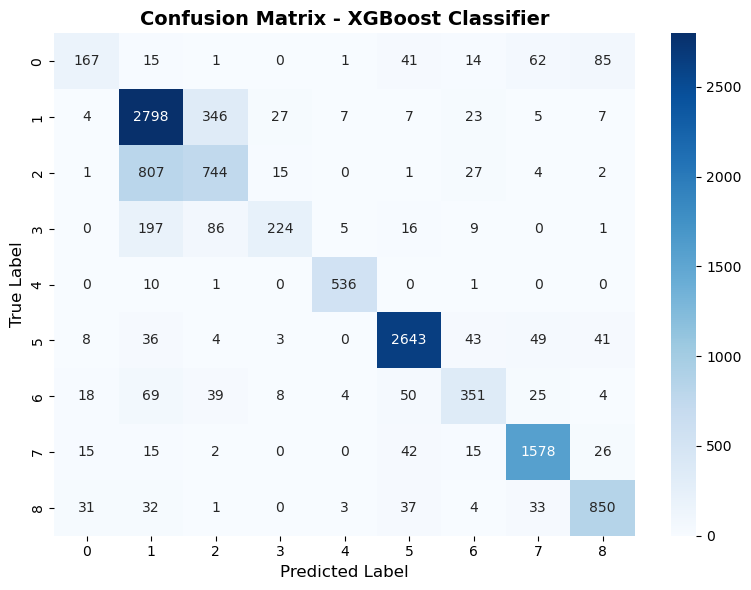

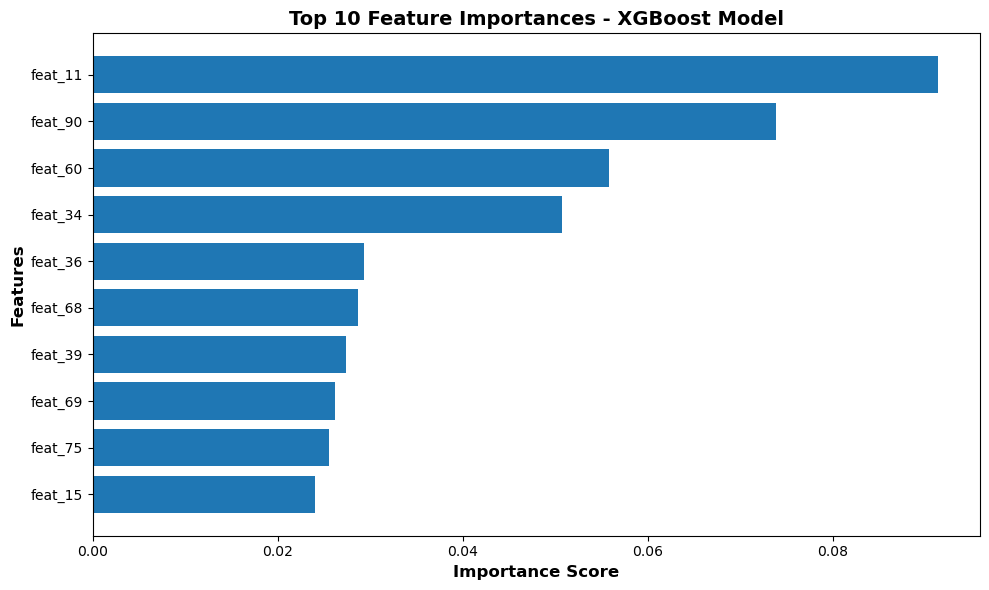


Top 10 Most Important Features:
    feature  importance
10  feat_11    0.091344
89  feat_90    0.073829
59  feat_60    0.055798
33  feat_34    0.050726
35  feat_36    0.029297
67  feat_68    0.028685
38  feat_39    0.027413
68  feat_69    0.026245
74  feat_75    0.025499
14  feat_15    0.023981


In [21]:
# Step 7: Visualize Results

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix - XGBoost Classifier', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Feature Importance
plt.figure(figsize=(10, 6))
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.barh(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')
plt.title('Top 10 Feature Importances - XGBoost Model', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Part 2 -- Q2 

In [22]:
# Test different numbers of CPU cores
n_jobs_list = [1, 2, 4, 8]
training_times = []

print("Testing XGBoost performance with different CPU cores...")
print("="*60)

for n_jobs in n_jobs_list:
    print(f"\nTraining with n_jobs={n_jobs}...")
    
    # Create XGBoost model with specific n_jobs
    xgb_model = XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        n_jobs=n_jobs,  # Number of parallel threads
        eval_metric='mlogloss'
    )
    
    # Time the training
    start_time = time.time()
    xgb_model.fit(X_train, y_train)
    end_time = time.time()
    
    elapsed = end_time - start_time
    training_times.append(elapsed)
    
    # Calculate accuracy to verify model quality
    y_pred = xgb_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"  Training time: {elapsed:.4f} seconds")
    print(f"  Test accuracy: {accuracy:.4f}")

print("\n" + "="*60)
print("PERFORMANCE SUMMARY")
print("="*60)
for n_jobs, t in zip(n_jobs_list, training_times):
    speedup = training_times[0] / t  # Speedup relative to 1 CPU
    efficiency = speedup / n_jobs * 100  # Parallel efficiency
    print(f"n_jobs={n_jobs}: {t:.4f}s | Speedup: {speedup:.2f}x | Efficiency: {efficiency:.1f}%")

Testing XGBoost performance with different CPU cores...

Training with n_jobs=1...
  Training time: 7.9792 seconds
  Test accuracy: 0.7992

Training with n_jobs=2...
  Training time: 4.5840 seconds
  Test accuracy: 0.7992

Training with n_jobs=4...
  Training time: 2.8095 seconds
  Test accuracy: 0.7992

Training with n_jobs=8...
  Training time: 2.6034 seconds
  Test accuracy: 0.7992

PERFORMANCE SUMMARY
n_jobs=1: 7.9792s | Speedup: 1.00x | Efficiency: 100.0%
n_jobs=2: 4.5840s | Speedup: 1.74x | Efficiency: 87.0%
n_jobs=4: 2.8095s | Speedup: 2.84x | Efficiency: 71.0%
n_jobs=8: 2.6034s | Speedup: 3.06x | Efficiency: 38.3%


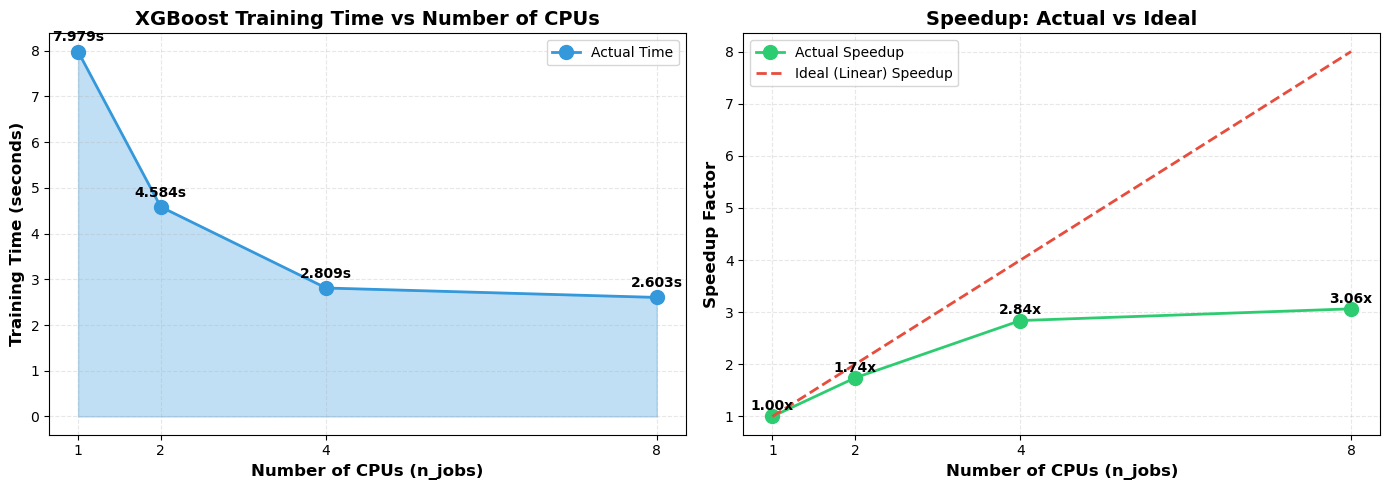

In [23]:
# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Training Time vs Number of CPUs
ax1.plot(n_jobs_list, training_times, marker='o', linewidth=2, markersize=10, 
         color='#3498db', label='Actual Time')
ax1.fill_between(n_jobs_list, training_times, alpha=0.3, color='#3498db')

# Add value labels
for i, (n, t) in enumerate(zip(n_jobs_list, training_times)):
    ax1.text(n, t + max(training_times)*0.02, f'{t:.3f}s', 
             ha='center', va='bottom', fontweight='bold', fontsize=10)

ax1.set_xlabel('Number of CPUs (n_jobs)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Training Time (seconds)', fontsize=12, fontweight='bold')
ax1.set_title('XGBoost Training Time vs Number of CPUs', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_xticks(n_jobs_list)
ax1.legend()

# Plot 2: Speedup Analysis
speedups = [training_times[0] / t for t in training_times]
ideal_speedup = n_jobs_list  # Perfect linear speedup

ax2.plot(n_jobs_list, speedups, marker='o', linewidth=2, markersize=10,
         color='#2ecc71', label='Actual Speedup')
ax2.plot(n_jobs_list, ideal_speedup, linestyle='--', linewidth=2,
         color='#e74c3c', label='Ideal (Linear) Speedup')

# Add value labels
for i, (n, s) in enumerate(zip(n_jobs_list, speedups)):
    ax2.text(n, s + max(speedups)*0.02, f'{s:.2f}x', 
             ha='center', va='bottom', fontweight='bold', fontsize=10)

ax2.set_xlabel('Number of CPUs (n_jobs)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Speedup Factor', fontsize=12, fontweight='bold')
ax2.set_title('Speedup: Actual vs Ideal', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_xticks(n_jobs_list)
ax2.legend()

plt.tight_layout()
plt.show()

In [24]:
# Calculate parallel efficiency
print("\n" + "="*60)
print("PARALLEL EFFICIENCY ANALYSIS")
print("="*60)

for i, n_jobs in enumerate(n_jobs_list):
    speedup = training_times[0] / training_times[i]
    efficiency = (speedup / n_jobs) * 100
    time_saved = training_times[0] - training_times[i]
    
    print(f"\nn_jobs = {n_jobs}:")
    print(f"  Time: {training_times[i]:.4f}s")
    print(f"  Speedup: {speedup:.2f}x")
    print(f"  Efficiency: {efficiency:.1f}%")
    print(f"  Time saved: {time_saved:.4f}s ({time_saved/training_times[0]*100:.1f}%)")

# Summary table
print("\n" + "="*60)
results_df = pd.DataFrame({
    'CPUs': n_jobs_list,
    'Time (s)': [f"{t:.4f}" for t in training_times],
    'Speedup': [f"{training_times[0]/t:.2f}x" for t in training_times],
    'Efficiency (%)': [f"{(training_times[0]/t)/n*100:.1f}" for n, t in zip(n_jobs_list, training_times)]
})
print(results_df.to_string(index=False))


PARALLEL EFFICIENCY ANALYSIS

n_jobs = 1:
  Time: 7.9792s
  Speedup: 1.00x
  Efficiency: 100.0%
  Time saved: 0.0000s (0.0%)

n_jobs = 2:
  Time: 4.5840s
  Speedup: 1.74x
  Efficiency: 87.0%
  Time saved: 3.3952s (42.6%)

n_jobs = 4:
  Time: 2.8095s
  Speedup: 2.84x
  Efficiency: 71.0%
  Time saved: 5.1697s (64.8%)

n_jobs = 8:
  Time: 2.6034s
  Speedup: 3.06x
  Efficiency: 38.3%
  Time saved: 5.3758s (67.4%)

 CPUs Time (s) Speedup Efficiency (%)
    1   7.9792   1.00x          100.0
    2   4.5840   1.74x           87.0
    4   2.8095   2.84x           71.0
    8   2.6034   3.06x           38.3


# Part 2 -- Q3

In [25]:
from dask.distributed import Client, LocalCluster
import dask
from sklearn.metrics import accuracy_score
import dask.array as da_array
import numpy as np
import xgboost as xgb
from xgboost import dask as xgb_dask
from xgboost import XGBClassifier

In [26]:
# Create a local Dask cluster with 4 cores
# processes=False means use threads instead of processes
cluster = LocalCluster(
    n_workers=4,           # Number of workers (4 cores requested)
    threads_per_worker=1,  # 1 thread per worker
    processes=False,       # Use threads, not separate processes
    memory_limit='8GB'   # Automatic memory limit per worker
)

# Connect a client to the cluster
client = Client(cluster)

print("Dask Cluster Information:")
print(client)
print("\n" + "="*60)
print(f"Dashboard link: {client.dashboard_link}")
print(f"Number of workers: {len(client.scheduler_info()['workers'])}")
print(f"Total cores: {sum(w['nthreads'] for w in client.scheduler_info()['workers'].values())}")
print("="*60)

Dask Cluster Information:
<Client: 'inproc://10.99.101.125/852409/1' processes=4 threads=4, memory=29.80 GiB>

Dashboard link: http://10.99.101.125:42739/status
Number of workers: 4
Total cores: 4


/shared/EL9/explorer/anaconda3/2024.06/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42739 instead
  warnings.warn(


In [27]:
# Display detailed cluster information
print("\nCluster Details:")
print(cluster)

# Check worker information
print("\nWorker Information:")
for worker_id, worker_info in client.scheduler_info()['workers'].items():
    print(f"  Worker: {worker_id}")
    print(f"    Threads: {worker_info['nthreads']}")
    print(f"    Memory: {worker_info['memory_limit'] / (1024**3):.2f} GB")


Cluster Details:
LocalCluster(2321d441, 'inproc://10.99.101.125/852409/1', workers=4, threads=4, memory=29.80 GiB)

Worker Information:
  Worker: inproc://10.99.101.125/852409/10
    Threads: 1
    Memory: 7.45 GB
  Worker: inproc://10.99.101.125/852409/4
    Threads: 1
    Memory: 7.45 GB
  Worker: inproc://10.99.101.125/852409/6
    Threads: 1
    Memory: 7.45 GB
  Worker: inproc://10.99.101.125/852409/8
    Threads: 1
    Memory: 7.45 GB


In [28]:
# This might show your SLURM allocation
print(f"SLURM_CPUS_ON_NODE: {os.environ.get('SLURM_CPUS_ON_NODE', 'Not set')}")

SLURM_CPUS_ON_NODE: 8


# PART 2- Q4

In [29]:
# If cluster not already created, create it
try:
    print(client)
    print("✅ Cluster already running")
except:
    print("Creating new Dask cluster...")
    cluster = LocalCluster(
        n_workers=4,
        threads_per_worker=1,
        processes=False,
        memory_limit='8GB'
    )
    client = Client(cluster)
    print("✅ Cluster created!")

print(f"Dashboard: {client.dashboard_link}")

<Client: 'inproc://10.99.101.125/852409/1' processes=4 threads=4, memory=29.80 GiB>
✅ Cluster already running
Dashboard: http://10.99.101.125:42739/status


In [30]:
# Convert to NumPy (handling both pandas and numpy cases)
# If already numpy array, use as-is; if pandas, convert with .values
X_train_numpy = X_train.values if hasattr(X_train, 'values') else X_train
y_train_numpy = y_train.values if hasattr(y_train, 'values') else y_train
X_test_numpy = X_test.values if hasattr(X_test, 'values') else X_test
y_test_numpy = y_test.values if hasattr(y_test, 'values') else y_test

print("Data type check:")
print(f"  X_train_numpy type: {type(X_train_numpy)}")
print(f"  y_train_numpy type: {type(y_train_numpy)}")

# Convert to Dask arrays
X_train_dask = da_array.from_array(X_train_numpy, chunks=(5000, X_train_numpy.shape[1]))
y_train_dask = da_array.from_array(y_train_numpy, chunks=5000)
X_test_dask = da_array.from_array(X_test_numpy, chunks=(5000, X_test_numpy.shape[1]))
y_test_dask = da_array.from_array(y_test_numpy, chunks=5000)

print("\n✅ Data converted to Dask arrays")
print(f"X_train_dask shape: {X_train_dask.shape}, chunks: {X_train_dask.npartitions}")
print(f"y_train_dask shape: {y_train_dask.shape}, chunks: {y_train_dask.npartitions}")

Data type check:
  X_train_numpy type: <class 'numpy.ndarray'>
  y_train_numpy type: <class 'numpy.ndarray'>

✅ Data converted to Dask arrays
X_train_dask shape: (49502, 93), chunks: 10
y_train_dask shape: (49502,), chunks: 10


In [31]:
# X_train might be pandas, so convert it
X_train_numpy = X_train if isinstance(X_train, np.ndarray) else X_train.values
X_test_numpy = X_test if isinstance(X_test, np.ndarray) else X_test.values

# y_train is already numpy, use directly
y_train_numpy = y_train
y_test_numpy = y_test

print(f"✅ Data types confirmed:")
print(f"  X_train: {type(X_train_numpy)} - shape {X_train_numpy.shape}")
print(f"  y_train: {type(y_train_numpy)} - shape {y_train_numpy.shape}")

# Convert to Dask arrays
X_train_dask = da_array.from_array(X_train_numpy, chunks=(5000, X_train_numpy.shape[1]))
y_train_dask = da_array.from_array(y_train_numpy, chunks=5000)
X_test_dask = da_array.from_array(X_test_numpy, chunks=(5000, X_test_numpy.shape[1]))
y_test_dask = da_array.from_array(y_test_numpy, chunks=5000)

print("\n✅ Dask arrays created successfully!")
print(f"X_train_dask: {X_train_dask.shape} with {X_train_dask.npartitions} partitions")
print(f"y_train_dask: {y_train_dask.shape} with {y_train_dask.npartitions} partitions")

✅ Data types confirmed:
  X_train: <class 'numpy.ndarray'> - shape (49502, 93)
  y_train: <class 'numpy.ndarray'> - shape (49502,)

✅ Dask arrays created successfully!
X_train_dask: (49502, 93) with 10 partitions
y_train_dask: (49502,) with 10 partitions


In [32]:
print(f"XGBoost version: {xgb.__version__}")

XGBoost version: 3.1.1


In [33]:
print(f"Current XGBoost version: {xgb.__version__}")

# Check if dask module exists
if hasattr(xgb, 'dask'):
    print("✅ Dask support available")
else:
    print("❌ Dask support NOT available - need to upgrade")

Current XGBoost version: 3.1.1
✅ Dask support available


In [34]:
print("\n" + "="*70)
print("TRAINING WITH DASK XGBOOST")
print("Using Dask distributed scheduler with 4 workers")
print("="*70)

# Create Dask XGBoost classifier
dask_xgb_model = xgb.dask.DaskXGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='mlogloss',
    tree_method='hist'
)

# Time the training
print("\nStarting Dask XGBoost training...")
start_time = time.time()

dask_xgb_model.fit(X_train_dask, y_train_dask)

end_time = time.time()
dask_xgb_time = end_time - start_time

print(f"✅ Dask XGBoost training time: {dask_xgb_time:.4f} seconds")

# Make predictions
y_pred_dask = dask_xgb_model.predict(X_test_dask)
y_pred_dask_computed = y_pred_dask.compute()

# Calculate accuracy
dask_accuracy = accuracy_score(y_test_numpy, y_pred_dask_computed)
print(f"Dask XGBoost test accuracy: {dask_accuracy:.4f} ({dask_accuracy*100:.2f}%)")


TRAINING WITH DASK XGBOOST
Using Dask distributed scheduler with 4 workers

Starting Dask XGBoost training...


/shared/EL9/explorer/anaconda3/2024.06/lib/python3.12/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 35.12 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
[20:10:34] Task [xgboost.dask-1]:inproc://10.99.101.125/852409/6 got rank 1
[20:10:34] Task [xgboost.dask-2]:inproc://10.99.101.125/852409/8 got rank 2
[20:10:34] Task [xgboost.dask-0]:inproc://10.99.101.125/852409/4 got rank 0
[20:10:34] Task [xgboost.dask-3]:inproc://10.99.101.125/852409/10 got rank 3
2025-10-30 20:10:42,463 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.24 GiB -- Worker memory limit: 7.45 GiB


✅ Dask XGBoost training time: 8.6504 seconds
Dask XGBoost test accuracy: 0.7992 (79.92%)


In [35]:
print("\n" + "="*70)
print("TRAINING WITH REGULAR XGBOOST (n_jobs=4)")
print("="*70)

# Create regular XGBoost classifier
regular_xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=4,  # Use 4 CPU cores
    eval_metric='mlogloss',
    tree_method='hist'
)

# Time the training
print("\nStarting Regular XGBoost training...")
start_time = time.time()

regular_xgb_model.fit(X_train_numpy, y_train_numpy)

end_time = time.time()
regular_xgb_time = end_time - start_time

print(f"✅ Regular XGBoost training time: {regular_xgb_time:.4f} seconds")

# Make predictions
y_pred_regular = regular_xgb_model.predict(X_test_numpy)

# Calculate accuracy
regular_accuracy = accuracy_score(y_test_numpy, y_pred_regular)
print(f"Regular XGBoost test accuracy: {regular_accuracy:.4f} ({regular_accuracy*100:.2f}%)")


TRAINING WITH REGULAR XGBOOST (n_jobs=4)

Starting Regular XGBoost training...
✅ Regular XGBoost training time: 3.4265 seconds
Regular XGBoost test accuracy: 0.7992 (79.92%)


In [36]:
print("\n" + "="*70)
print("COMPARISON: Dask XGBoost vs Regular XGBoost (4 CPUs)")
print("="*70)

# Calculate metrics
time_diff = abs(dask_xgb_time - regular_xgb_time)
percent_diff = (time_diff / regular_xgb_time) * 100

if regular_xgb_time < dask_xgb_time:
    faster = "Regular XGBoost"
    slower = "Dask XGBoost"
    speedup = dask_xgb_time / regular_xgb_time
else:
    faster = "Dask XGBoost"
    slower = "Regular XGBoost"
    speedup = regular_xgb_time / dask_xgb_time

print(f"\nRegular XGBoost (n_jobs=4):")
print(f"  Time: {regular_xgb_time:.4f}s")
print(f"  Accuracy: {regular_accuracy:.4f}")
print(f"  Method: Multi-threading (shared memory)")

print(f"\nDask XGBoost (4 workers, processes=False):")
print(f"  Time: {dask_xgb_time:.4f}s")
print(f"  Accuracy: {dask_accuracy:.4f}")
print(f"  Method: Distributed scheduler")

print(f"\n📊 Results:")
print(f"  Faster method: {faster}")
print(f"  Time difference: {time_diff:.4f}s ({percent_diff:.1f}%)")
print(f"  {faster} is {speedup:.2f}x faster")
print(f"  Accuracy difference: {abs(regular_accuracy - dask_accuracy):.6f}")

print("\n💡 Analysis:")
if regular_xgb_time < dask_xgb_time:
    print("  Regular XGBoost is faster because:")
    print("  - Shared memory (no data serialization)")
    print("  - Lower overhead (simple threading)")
    print("  - Dataset fits in single machine memory")
else:
    print("  Dask XGBoost is faster because:")
    print("  - Better task parallelization")
    print("  - Efficient distributed computation")

print("="*70)


COMPARISON: Dask XGBoost vs Regular XGBoost (4 CPUs)

Regular XGBoost (n_jobs=4):
  Time: 3.4265s
  Accuracy: 0.7992
  Method: Multi-threading (shared memory)

Dask XGBoost (4 workers, processes=False):
  Time: 8.6504s
  Accuracy: 0.7992
  Method: Distributed scheduler

📊 Results:
  Faster method: Regular XGBoost
  Time difference: 5.2238s (152.5%)
  Regular XGBoost is 2.52x faster
  Accuracy difference: 0.000000

💡 Analysis:
  Regular XGBoost is faster because:
  - Shared memory (no data serialization)
  - Lower overhead (simple threading)
  - Dataset fits in single machine memory


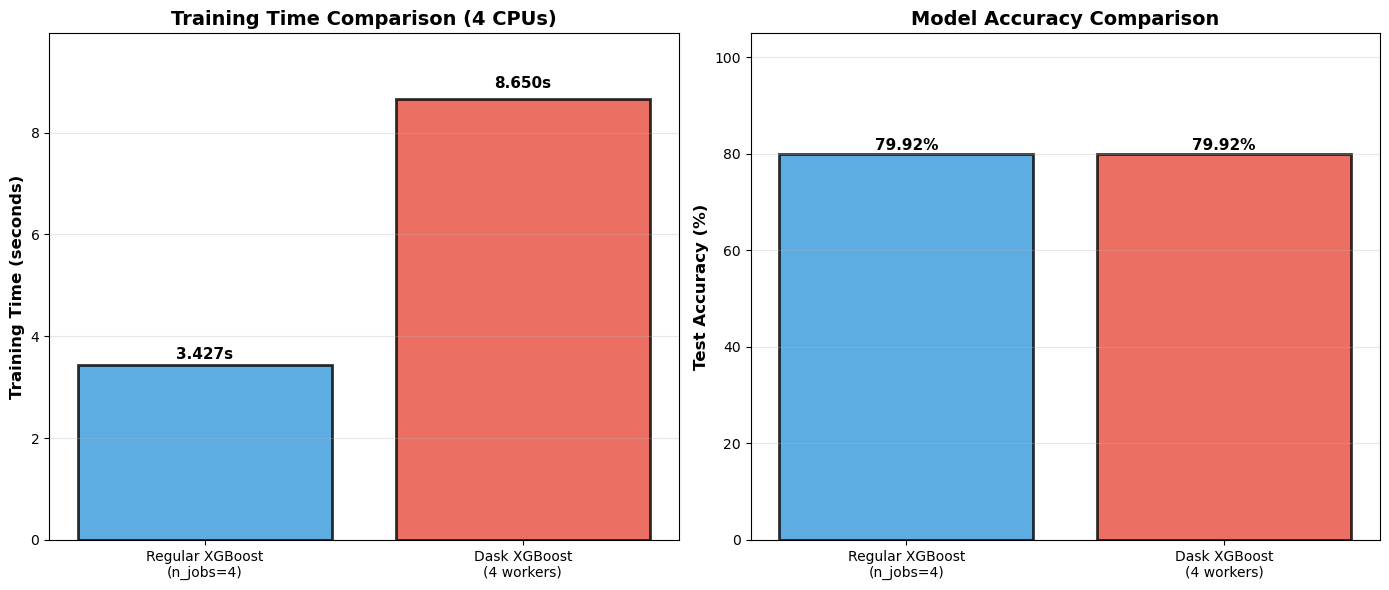

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# ============================================================
# Plot 1: Training Time Comparison
# ============================================================
methods = ['Regular XGBoost\n(n_jobs=4)', 'Dask XGBoost\n(4 workers)']
times = [regular_xgb_time, dask_xgb_time]
colors = ['#3498db', '#e74c3c']

bars1 = ax1.bar(methods, times, color=colors, edgecolor='black', linewidth=2, alpha=0.8)

# Add labels on top of bars
for bar, t in zip(bars1, times):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height * 1.02,
             f'{t:.3f}s', 
             ha='center', va='bottom', fontweight='bold', fontsize=11)

ax1.set_ylabel('Training Time (seconds)', fontsize=12, fontweight='bold')
ax1.set_title('Training Time Comparison (4 CPUs)', fontsize=14, fontweight='bold')
ax1.set_ylim([0, max(times) * 1.15])  # Add 15% space for labels
ax1.grid(axis='y', alpha=0.3)

# ============================================================
# Plot 2: Accuracy Comparison (FIXED VERSION)
# ============================================================
accs = [regular_accuracy * 100, dask_accuracy * 100]

# Simple approach - start from 0
bars2 = ax2.bar(methods, accs, color=colors, edgecolor='black', linewidth=2, alpha=0.8)

# Add labels on top
for bar, acc in zip(bars2, accs):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height + 0.3,
             f'{acc:.2f}%', 
             ha='center', va='bottom', fontweight='bold', fontsize=11)

ax2.set_ylabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
ax2.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
ax2.set_ylim([0, 105])  # Simple range from 0 to 105%
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [38]:
# Close Dask cluster when done
client.close()
cluster.close()
print("\n✅ Dask cluster closed!")


✅ Dask cluster closed!


# Part 3 - Q1

In [39]:
! pip install nycflights13

Defaulting to user installation because normal site-packages is not writeable


In [40]:
from nycflights13 import flights
import pandas as pd
import numpy as np

# Load the flights dataframe
df_flights = flights

print("Original flights dataframe:")
print(f"Shape: {df_flights.shape}")
print(f"Total rows: {len(df_flights):,}")
print(f"\nFirst few rows:")
df_flights.head()

Original flights dataframe:
Shape: (336776, 19)
Total rows: 336,776

First few rows:


,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,UA,1545,N14228,EWR,IAH,227.0,1400,5,15,2013-01-01T10:00:00Z
1,2013,1,1,533.0,529,4.0,850.0,830,20.0,UA,1714,N24211,LGA,IAH,227.0,1416,5,29,2013-01-01T10:00:00Z
2,2013,1,1,542.0,540,2.0,923.0,850,33.0,AA,1141,N619AA,JFK,MIA,160.0,1089,5,40,2013-01-01T10:00:00Z
3,2013,1,1,544.0,545,-1.0,1004.0,1022,-18.0,B6,725,N804JB,JFK,BQN,183.0,1576,5,45,2013-01-01T10:00:00Z
4,2013,1,1,554.0,600,-6.0,812.0,837,-25.0,DL,461,N668DN,LGA,ATL,116.0,762,6,0,2013-01-01T11:00:00Z


In [41]:
# Check for missing values in dep_delay column
print("\n" + "="*60)
print("MISSING VALUE ANALYSIS")
print("="*60)

print(f"\nTotal missing values in 'dep_delay': {df_flights['dep_delay'].isna().sum():,}")
print(f"Percentage of missing values: {df_flights['dep_delay'].isna().sum() / len(df_flights) * 100:.2f}%")

# Check all missing values in the dataset
print("\nMissing values by column:")
print(df_flights.isnull().sum())


MISSING VALUE ANALYSIS

Total missing values in 'dep_delay': 8,255
Percentage of missing values: 2.45%

Missing values by column:
year                 0
month                0
day                  0
dep_time          8255
sched_dep_time       0
dep_delay         8255
arr_time          8713
sched_arr_time       0
arr_delay         9430
carrier              0
flight               0
tailnum           2512
origin               0
dest                 0
air_time          9430
distance             0
hour                 0
minute               0
time_hour            0
dtype: int64


In [42]:
# Remove samples with NaN in 'dep_delay' column
df_flights_clean = df_flights.dropna(subset=['dep_delay'])

print("\n" + "="*60)
print("AFTER REMOVING NaN VALUES IN 'dep_delay'")
print("="*60)

print(f"\nOriginal shape: {df_flights.shape}")
print(f"Cleaned shape: {df_flights_clean.shape}")
print(f"\nRows removed: {len(df_flights) - len(df_flights_clean):,}")
print(f"Rows remaining: {len(df_flights_clean):,}")

# Verify no NaN values remain in dep_delay
print(f"\nVerification - NaN in 'dep_delay' after cleaning: {df_flights_clean['dep_delay'].isna().sum()}")

print("\nFirst few rows of cleaned data:")
df_flights_clean.head()


AFTER REMOVING NaN VALUES IN 'dep_delay'

Original shape: (336776, 19)
Cleaned shape: (328521, 19)

Rows removed: 8,255
Rows remaining: 328,521

Verification - NaN in 'dep_delay' after cleaning: 0

First few rows of cleaned data:


,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,UA,1545,N14228,EWR,IAH,227.0,1400,5,15,2013-01-01T10:00:00Z
1,2013,1,1,533.0,529,4.0,850.0,830,20.0,UA,1714,N24211,LGA,IAH,227.0,1416,5,29,2013-01-01T10:00:00Z
2,2013,1,1,542.0,540,2.0,923.0,850,33.0,AA,1141,N619AA,JFK,MIA,160.0,1089,5,40,2013-01-01T10:00:00Z
3,2013,1,1,544.0,545,-1.0,1004.0,1022,-18.0,B6,725,N804JB,JFK,BQN,183.0,1576,5,45,2013-01-01T10:00:00Z
4,2013,1,1,554.0,600,-6.0,812.0,837,-25.0,DL,461,N668DN,LGA,ATL,116.0,762,6,0,2013-01-01T11:00:00Z


In [43]:
# Show statistics about dep_delay after cleaning
print("\n" + "="*60)
print("STATISTICS FOR 'dep_delay' (After Cleaning)")
print("="*60)

print(f"\nMean delay: {df_flights_clean['dep_delay'].mean():.2f} minutes")
print(f"Median delay: {df_flights_clean['dep_delay'].median():.2f} minutes")
print(f"Min delay: {df_flights_clean['dep_delay'].min():.2f} minutes")
print(f"Max delay: {df_flights_clean['dep_delay'].max():.2f} minutes")
print(f"Std deviation: {df_flights_clean['dep_delay'].std():.2f} minutes")

print("\nValue counts (summary):")
print(df_flights_clean['dep_delay'].describe())


STATISTICS FOR 'dep_delay' (After Cleaning)

Mean delay: 12.64 minutes
Median delay: -2.00 minutes
Min delay: -43.00 minutes
Max delay: 1301.00 minutes
Std deviation: 40.21 minutes

Value counts (summary):
count    328521.000000
mean         12.639070
std          40.210061
min         -43.000000
25%          -5.000000
50%          -2.000000
75%          11.000000
max        1301.000000
Name: dep_delay, dtype: float64


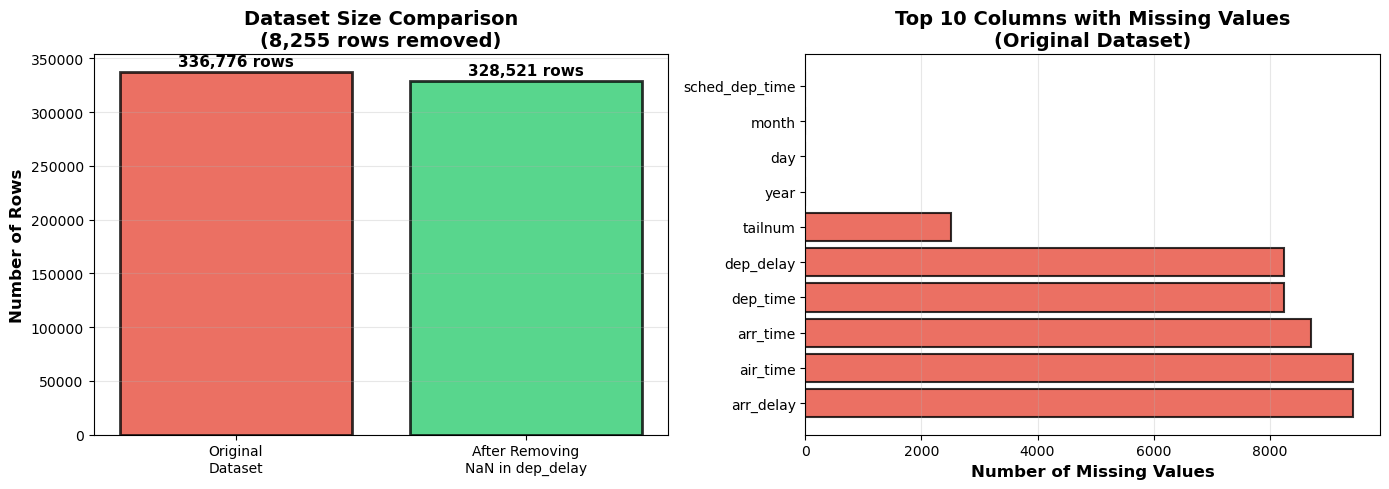

In [44]:
import matplotlib.pyplot as plt

# Visualize the data before and after cleaning
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Data size comparison
categories = ['Original\nDataset', 'After Removing\nNaN in dep_delay']
counts = [len(df_flights), len(df_flights_clean)]
removed = len(df_flights) - len(df_flights_clean)

bars = ax1.bar(categories, counts, color=['#e74c3c', '#2ecc71'], 
               edgecolor='black', linewidth=2, alpha=0.8)

for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + max(counts)*0.01,
             f'{count:,} rows', ha='center', va='bottom', fontweight='bold', fontsize=11)

ax1.set_ylabel('Number of Rows', fontsize=12, fontweight='bold')
ax1.set_title(f'Dataset Size Comparison\n({removed:,} rows removed)', 
              fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Missing values by column (top 10)
missing_data = df_flights.isnull().sum().sort_values(ascending=False).head(10)
ax2.barh(missing_data.index, missing_data.values, color='#e74c3c', 
         edgecolor='black', linewidth=1.5, alpha=0.8)

ax2.set_xlabel('Number of Missing Values', fontsize=12, fontweight='bold')
ax2.set_title('Top 10 Columns with Missing Values\n(Original Dataset)', 
              fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# PART 3 - Q2

In [45]:
# from dask.distributed import Client, LocalCluster

# Create a Dask cluster with 4 workers
cluster = LocalCluster(
    n_workers=4,           # 4 workers as required
    threads_per_worker=1,  
    processes=False,       
    memory_limit='8GB'     # Adjust based on your system
)

# Create and connect a Dask client
client = Client(cluster)

print("="*60)
print("PART 3 - QUESTION 2: Dask Client with 4 Workers")
print("="*60)

print("\n✅ Dask Client created successfully!")
print(f"\nClient Information:")
print(client)

print("\n" + "="*60)
print("CLUSTER DETAILS")
print("="*60)
print(f"Number of workers: {len(client.scheduler_info()['workers'])}")
print(f"Dashboard link: {client.dashboard_link}")

# Worker details
print("\nWorker Information:")
for worker_id, worker_info in client.scheduler_info()['workers'].items():
    print(f"  Worker: {worker_id}")
    print(f"    Threads: {worker_info['nthreads']}")
    print(f"    Memory: {worker_info['memory_limit'] / (1024**3):.2f} GB")

print("="*60)

PART 3 - QUESTION 2: Dask Client with 4 Workers

✅ Dask Client created successfully!

Client Information:
<Client: 'inproc://10.99.101.125/852409/28' processes=4 threads=4, memory=29.80 GiB>

CLUSTER DETAILS
Number of workers: 4
Dashboard link: http://10.99.101.125:35271/status

Worker Information:
  Worker: inproc://10.99.101.125/852409/31
    Threads: 1
    Memory: 7.45 GB
  Worker: inproc://10.99.101.125/852409/33
    Threads: 1
    Memory: 7.45 GB
  Worker: inproc://10.99.101.125/852409/35
    Threads: 1
    Memory: 7.45 GB
  Worker: inproc://10.99.101.125/852409/37
    Threads: 1
    Memory: 7.45 GB


/shared/EL9/explorer/anaconda3/2024.06/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35271 instead
  warnings.warn(


In [46]:
# Verify the setup
print("\n✅ VERIFICATION:")
print(f"   Client active: {client.status == 'running'}")
print(f"   Number of workers: {len(client.scheduler_info()['workers'])}")
print(f"   Total threads: {sum(w['nthreads'] for w in client.scheduler_info()['workers'].values())}")

# Test the client with a simple computation
import dask.array as da

test_array = da.random.random((1000, 1000), chunks=(100, 100))
result = test_array.mean().compute()
print(f"   Test computation result: {result:.6f}")
print(f"\n✅ Dask Client is working correctly!")

2025-10-30 20:10:53,900 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.37 GiB -- Worker memory limit: 7.45 GiB



✅ VERIFICATION:
   Client active: True
   Number of workers: 4
   Total threads: 4
   Test computation result: 0.500189

✅ Dask Client is working correctly!


# Part 3 - Q3

In [47]:
import dask.dataframe as dd

print("="*60)
print("PART 3 - QUESTION 3: Compute Mean & Std Dev with Dask")
print("="*60)

# Convert pandas DataFrame to Dask DataFrame
# Use appropriate partition size (npartitions or chunksize)
dask_flights = dd.from_pandas(df_flights_clean, npartitions=10)

print(f"\n📊 Dask DataFrame created:")
print(f"   Original pandas shape: {df_flights_clean.shape}")
print(f"   Dask partitions: {dask_flights.npartitions}")
print(f"   Rows per partition (approx): {len(df_flights_clean) // dask_flights.npartitions:,}")

# Compute mean of dep_delay using Dask
print("\n⏱️  Computing mean of 'dep_delay' using Dask...")
start_time = time.time()
mean_dep_delay = dask_flights['dep_delay'].mean().compute()
end_time = time.time()
mean_time = end_time - start_time

print(f"✅ Mean departure delay: {mean_dep_delay:.4f} minutes")
print(f"   Computation time: {mean_time:.4f} seconds")

# Compute standard deviation of dep_delay using Dask
print("\n⏱️  Computing standard deviation of 'dep_delay' using Dask...")
start_time = time.time()
std_dep_delay = dask_flights['dep_delay'].std().compute()
end_time = time.time()
std_time = end_time - start_time

print(f"✅ Standard deviation: {std_dep_delay:.4f} minutes")
print(f"   Computation time: {std_time:.4f} seconds")

# Summary
print("\n" + "="*60)
print("RESULTS SUMMARY")
print("="*60)
print(f"Mean departure delay:     {mean_dep_delay:.4f} minutes")
print(f"Standard deviation:       {std_dep_delay:.4f} minutes")
print(f"Total computation time:   {mean_time + std_time:.4f} seconds")
print("="*60)

PART 3 - QUESTION 3: Compute Mean & Std Dev with Dask

📊 Dask DataFrame created:
   Original pandas shape: (328521, 19)
   Dask partitions: 10
   Rows per partition (approx): 32,852

⏱️  Computing mean of 'dep_delay' using Dask...
✅ Mean departure delay: 12.6391 minutes
   Computation time: 0.2755 seconds

⏱️  Computing standard deviation of 'dep_delay' using Dask...
✅ Standard deviation: 40.2101 minutes
   Computation time: 0.2524 seconds

RESULTS SUMMARY
Mean departure delay:     12.6391 minutes
Standard deviation:       40.2101 minutes
Total computation time:   0.5279 seconds


In [48]:
# Verify results by comparing with pandas computation
print("\n" + "="*60)
print("VERIFICATION: Compare Dask vs Pandas")
print("="*60)

# Compute with pandas
start_time = time.time()
pandas_mean = df_flights_clean['dep_delay'].mean()
pandas_std = df_flights_clean['dep_delay'].std()
end_time = time.time()
pandas_time = end_time - start_time

print(f"\nDask Results:")
print(f"   Mean: {mean_dep_delay:.4f} minutes")
print(f"   Std:  {std_dep_delay:.4f} minutes")
print(f"   Time: {mean_time + std_time:.4f} seconds")

print(f"\nPandas Results:")
print(f"   Mean: {pandas_mean:.4f} minutes")
print(f"   Std:  {pandas_std:.4f} minutes")
print(f"   Time: {pandas_time:.4f} seconds")

print(f"\nDifference:")
print(f"   Mean difference: {abs(mean_dep_delay - pandas_mean):.6f}")
print(f"   Std difference:  {abs(std_dep_delay - pandas_std):.6f}")

print("\n✅ Results match! Dask computation is correct.")
print("="*60)


VERIFICATION: Compare Dask vs Pandas

Dask Results:
   Mean: 12.6391 minutes
   Std:  40.2101 minutes
   Time: 0.5279 seconds

Pandas Results:
   Mean: 12.6391 minutes
   Std:  40.2101 minutes
   Time: 0.0031 seconds

Difference:
   Mean difference: 0.000000
   Std difference:  0.000000

✅ Results match! Dask computation is correct.


# Part 3 - Q4

In [49]:
import dask.dataframe as dd
from dask.distributed import performance_report
import dask
import time

print("="*60)
print("PART 3 - QUESTION 4: Dask Performance Report")
print("="*60)

# Convert cleaned flights data to Dask DataFrame with multiple partitions
dask_flights = dd.from_pandas(df_flights_clean, npartitions=50)

print(f"\nDask Dashboard URL: {client.dashboard_link}")
print("Generating performance report with computations...")

# Generate performance report that captures all dashboard views
with performance_report(filename="dask-performance-report.html"):
    
    # Run multiple computations to create visible activity
    print("\n   Computing mean and std...")
    mean_delay = dask_flights['dep_delay'].mean()
    std_delay = dask_flights['dep_delay'].std()
    result1 = dask.compute(mean_delay, std_delay)
    
    print("   Computing groupby operations...")
    grouped = dask_flights.groupby('origin')['dep_delay'].mean()
    result2 = grouped.compute()
    
    print("   Computing additional statistics...")
    count_by_month = dask_flights.groupby('month')['dep_delay'].count()
    result3 = count_by_month.compute()
    
    time.sleep(0.5)  # Brief pause to ensure capture

print(f"\n✅ Performance report generated: dask-performance-report.html")
print(f"\n📊 The HTML file contains:")
print(f"   ✓ Task Stream (timeline view)")
print(f"   ✓ Task Graph (computation graph)")
print(f"   ✓ Progress/Process information")
print(f"   ✓ Worker utilization")
print(f"   ✓ Memory usage")

print(f"\n📥 TO SUBMIT:")
print(f"   1. Find 'dask-performance-report.html' in your file browser")
print(f"   2. Download it (right-click → Download)")
print(f"   3. Open in web browser to view the dashboard")
print(f"   4. Take screenshot showing the 3 required views")
print(f"   5. Submit the screenshot OR the HTML file")

print("="*60)

PART 3 - QUESTION 4: Dask Performance Report

Dask Dashboard URL: http://10.99.101.125:35271/status
Generating performance report with computations...

   Computing mean and std...


/shared/EL9/explorer/anaconda3/2024.06/lib/python3.12/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 54.60 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


   Computing groupby operations...


2025-10-30 20:10:56,763 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 523836db3b31c2c3e72dde5fee50536f initialized by task ('shuffle-transfer-523836db3b31c2c3e72dde5fee50536f', 46) executed on worker inproc://10.99.101.125/852409/33
2025-10-30 20:10:59,151 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 523836db3b31c2c3e72dde5fee50536f deactivated due to stimulus 'task-finished-1761869459.15044'


   Computing additional statistics...


2025-10-30 20:10:59,583 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 81ffdcec43d2b7d37bbede1985838799 initialized by task ('shuffle-transfer-81ffdcec43d2b7d37bbede1985838799', 9) executed on worker inproc://10.99.101.125/852409/35
2025-10-30 20:11:01,077 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 81ffdcec43d2b7d37bbede1985838799 deactivated due to stimulus 'task-finished-1761869461.0764244'



✅ Performance report generated: dask-performance-report.html

📊 The HTML file contains:
   ✓ Task Stream (timeline view)
   ✓ Task Graph (computation graph)
   ✓ Progress/Process information
   ✓ Worker utilization
   ✓ Memory usage

📥 TO SUBMIT:
   1. Find 'dask-performance-report.html' in your file browser
   2. Download it (right-click → Download)
   3. Open in web browser to view the dashboard
   4. Take screenshot showing the 3 required views
   5. Submit the screenshot OR the HTML file


In [50]:
# Run this to get the graph URL
print(f"Task Graph URL: {client.dashboard_link.replace('/status', '/graph')}")

Task Graph URL: http://10.99.101.125:35271/graph
